In [1]:
#brew install spatialindex
#pip3.7 install osmnx
#pip3.7 install networkx
import pandas as pd
import numpy as np
import geopandas as gpd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.10'

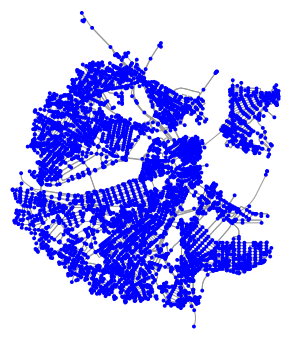

In [2]:
# create the street network within the area (42.35817°N 71.06369°W)
location_point = (42.35817, -71.06369)
G = ox.graph_from_point(location_point, distance=5000, distance_type='network', network_type='drive', simplify=False)
#G = ox.graph_from_place('Boston, Massachusetts, USA', network_type='drive', simplify=False)
G = ox.project_graph(G)
# simplify network with strict mode turned on
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, node_color='b', node_zorder=3)

In [3]:
# use "k" nodes (~10% of total amount is usually ok) for faster estimation
betweenness_centrality = nx.edge_betweenness_centrality(G, k = int(len(G.nodes())/10), normalized=True)

In [4]:
percentile75 = np.percentile(list(betweenness_centrality.values()), 75)

In [5]:
def highway_rank(highway):
    if   highway == 'motorway':
        return 0
    elif highway == 'motorway_link':
        return 1
    elif highway == 'trunk':
        return 2
    elif highway == 'trunk_link':
        return 3
    elif highway == 'primary':
        return 4
    elif highway == 'primary_link':
        return 5
    elif highway == 'secondary':
        return 6
    elif highway == 'secondary_link':
        return 7
    elif highway == 'tertiary':
        return 8
    elif highway == 'tertiary_link':
        return 9
    else:
        return 10

def edge_style(u, v, key, data):
    global percentile75
        
    bc = [betweenness_centrality[(u,v)]]
    highway = data['highway']
    
    if bc >= percentile75 and highway_rank(highway) <= 5:
        return ('red',2)
    elif bc >= percentile75 and highway_rank(highway) > 5:
        return ('green',2)
    elif bc < percentile75 and highway_rank(highway) <= 5:
        return ('yellow',2)
    elif bc < percentile75 and highway_rank(highway) > 5:
        return ('gray',0.5)
    else:
        # error
        return ('white',1)

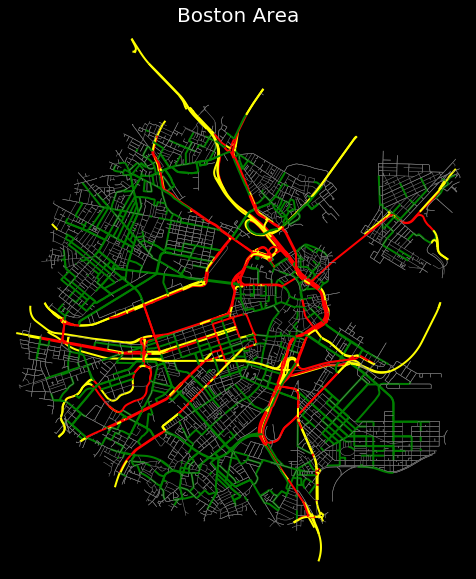

In [6]:
style = [edge_style(u, v, key, data) for u, v, key, data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_size=0,
                        edge_color=np.array(style)[:,0], edge_linewidth=np.array(style)[:,1], edge_alpha=1,
                        fig_height=10, bgcolor='black', show=False, close=False)
ax.set_title('Boston Area', color='white', fontsize=20)
#plt.savefig('Boston Area.jpg', facecolor='black', bbox_inches='tight', dpi=300)
plt.show()

In [7]:
# save street network as ESRI shapefile to work with in GIS
#ox.save_graph_shapefile(G, filename='Boston Area')

In [8]:
# save street network as GraphML file to work with in networkx or gephi
#ox.save_graphml(G, filename='Boston Area.graphml')
# load the street network from GraphML file
#G = ox.load_graphml('Boston Area.graphml')